# City footprint

This notebook explores protoideas for a data set of:
* 200 cities around the world, with populations metadata.
* Hyperspectral data for several cities, and others villages and cities closeby.
* Landsat and Hyperion where available.

This notebook:
* [Plots basic information and maps of the dataset](#Plot-a-map-and-basic-info-from-the-cities-dataset)
* Load an example city that is available on macro, micro, and Landsat:
    * [from Landsat](#Load-example-city-from-Landsat)
    * from macro Satellogic

# Plot a map and basic info from the cities dataset

In [1]:
import os
# Set Mapbox Access Token to create visual.  https://www.mapbox.com/account/access-tokens
token = "pk.eyJ1IjoiYnJ1bm9zYW4iLCJhIjoic3FUc1dJWSJ9.v0525WacYWcsHM1KtbZitg"
print("Mapbox token is:", token)

Mapbox token is: pk.eyJ1IjoiYnJ1bm9zYW4iLCJhIjoic3FUc1dJWSJ9.v0525WacYWcsHM1KtbZitg


In [2]:
from mapboxgl.viz import *
from mapboxgl.utils import *
import pandas as pd

# Load data from csv
data_url = 'https://gist.githubusercontent.com/brunosan/52058909cb5fda0c6830c32c10f47698/raw/369bc0f60cde72d982c7e056aa2db402896a973a/cities.csv'
df = pd.read_csv(data_url, header=0)

# Create geojson data object
df_to_geojson(
    df,
    filename="cdec.geojson",
    precision=4
)

df.head(2)

Country Name City Name      lat      lon Population 1990  Population 2000  \
0  Afghanistan     Kabul  34.5289  69.1725         1549320        2401109.0   
1      Algeria   Algiers  36.7525   3.0420         1797068        2140577.0   

   Population 2010  %Growth Rate 1990-2001  %Growth Rate 2000-2011  \
0          3722320                    4.38                    4.38   
1          2432023                    1.75                    1.28   

                   Source  
0  UN Population Division  
1  UN Population Division

In [3]:
# plot interactive map

import pysal.esda.mapclassify as mapclassify
# Generate data breaks and color stops from colorBrewer
color_breaks = mapclassify.Natural_Breaks(
    df['%Growth Rate 2000-2011'], k=8, initial=0).bins
color_stops = create_color_stops(color_breaks, colors='RdYlGn')

# Generate radius breaks from data domain and circle-radius range
radius_breaks = mapclassify.Natural_Breaks(
    df["Population 2010"], k=8, initial=0).bins
radius_stops = create_radius_stops(radius_breaks, 3, 10)

# Create the viz from the dataframe
viz = GraduatedCircleViz('cdec.geojson',
                         access_token=token,
                         height='400px',
                         color_property="%Growth Rate 2000-2011",
                         color_stops=color_stops,
                         radius_property="Population 2010",
                         radius_stops=radius_stops,
                         center=(0, 0),
                         zoom=1,
                         below_layer='waterway-label')

viz.show()

In [4]:
# Another example plot, histogram of the growth rate, per city.
df['%Growth Rate 2000-2011'].plot.hist()

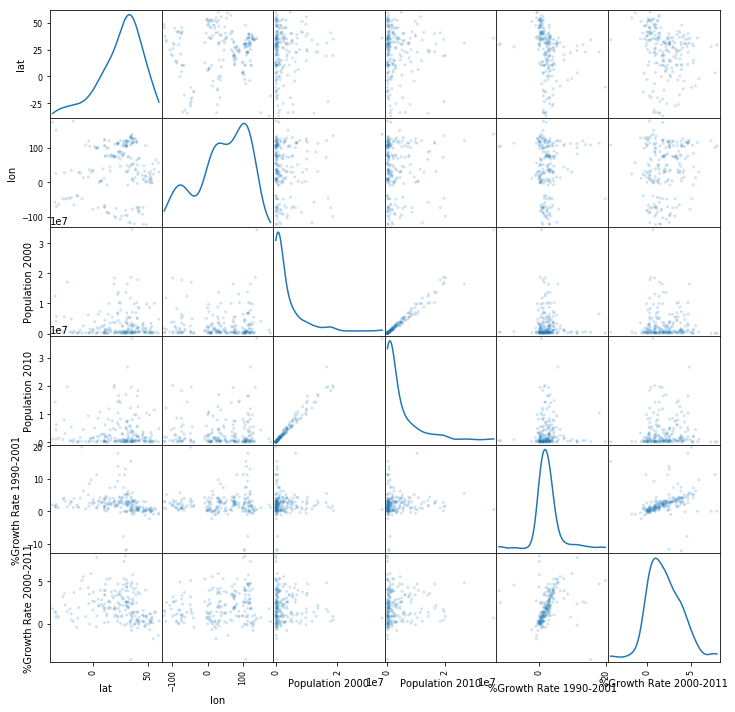

In [5]:
# last example visualization
# Scatterplot of each parameter against others, and the kernel (~histogram) in the diagonal
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde');

# Load example location from several instruments

Let's load the same spot, e.g. Baghdad, in diferent sensors.


In [6]:
# SATELLOGIC
satellogic_macro_ids = ['newsat3_macro_cube_82512b8f6917447790d5786c2b3aed8c_0_4_6',  # 2017-12-28T14:13:25
                        'newsat3_macro_cube_63a0c289b0bb4afaaccc420f16e75c8b_0_3_46']  # 2017-11-17T07:10:05
satellogic_micro_ids = ['newsat3_micro_micro_multiband_0bc2b6d1e58e4be489917d27dddea3e7_0_4_1',  # 2018-01-12T07:12:06
                        # 2017-12-04T06:13:07
                        'newsat3_micro_micro_multiband_4b4e858012d54cfd8f21afbbf1e6d7ae_0_4_0',
                        'newsat3_micro_micro_multiband_b8589ec615a646f58181184475b8cd6e_0_3_45']  # 2017-12-03T06:22:32
# Landsat 8 https://earthexplorer.usgs.gov/
landsat_8_ids = ['LC08_L1TP_169037_20171117_20171122_01_T1',  # 17-NOV-17T07:39:46
                 'LC08_L1TP_169037_20171219_20171224_01_T1']  # 19-DEC-17

### Download the data if you don't have it

In [ ]:
# download macro and micro
# Authenticate on telluric
# Documentation https://integration.telluric.satellogic.com/docs/

import requests
url = 'https://auth.telluric.satellogic.com/api-token-auth/'
payload = {'username': 'stanfordhackathon', 'password': 'hack2018'}

print("Getting token...")
r = requests.post(url, data=payload)
if r.status_code != 200:
    raise ValueError("Telluric response error: %s" % r.text)
telluric_token = "JWT "+r.json()['token']
print(telluric_token[0:10]+"*masked*")
import os
from IPython.lib import backgroundjobs as bg
import ipywidgets as widgets

# get all rasters associated with the scence_id

# get download id for the whole raster
url = 'https://telluric.satellogic.com/v2/scenes/download/'

scene_id = 'newsat3_macro_cube_257e8052c6d94b72ada0b788173791fa_0_4_3'
header = {'authorization': telluric_token}
data = {'scene_id': scene_id,
        'async': 1}  # Important! This will prepare the download in the background for us
print("Requesting download...")
r = requests.get(url, params=data, headers=header)
if r.status_code != 200:
    raise ValueError("Telluric response error: %s" % r.text)
response = r.json()
response

import time
# after a while (10 minutes), the download is ready
response = requests.get(r.json()['status_path'], headers=header).json()
print(response['status'], end=': ')
while response['status'] == 'Creating':
    time.sleep(5)
    response = requests.get(r.json()['status_path'], headers=header).json()
    print("%2.1f%%, " % response['progress'], end="")
print('. Ready to download.')

# download raster to a file (<10 minutes with a good connection)
url = response['download_url']
folder = "../data/satellogic/macro/"+scene_id+"/"
if not os.path.exists(folder):
    os.makedirs(folder)
filename = folder+response['filename']
header = {'authorization': telluric_token}

# http://docs.python-requests.org/en/master/user/quickstart/#raw-response-content
r = requests.get(url, headers=header, stream=True)
if r.status_code != 200:
    raise ValueError("Telluric response error: %s" % r.text)
print(filename)
with open(filename, 'wb') as fd:
    i = 0
    total = int(r.headers.get('content-length'))
    for chunk in r.iter_content(chunk_size=1024):
        fd.write(chunk)
        i += 1
        print("\rDownloading %3.2f%%" % (i*1024./total*100), end='')
print("done")
# unzip the contents
import os
from zipfile import ZipFile

with ZipFile(filename, 'r') as fp:
    fp.extractall(folder)

Getting token...
JWT eyJhbG*masked*
Requesting download...
Creating: 25.4%, 30.7%, 32.1%, 33.3%, 35.2%, 36.0%, 38.0%, 39.1%, 40.7%, 41.9%, 43.9%, 45.0%, 47.0%, 48.6%, 49.7%, 51.7%, 52.8%, 54.8%, 56.4%, 57.5%, 58.7%, 60.7%, 62.2%, 63.4%, 65.4%, 66.5%, 68.1%, 68.5%, 70.1%, 71.2%, 72.4%, 72.4%, 73.2%, 73.2%, 74.3%, 75.2%, 75.2%, 76.0%, 76.3%, 77.1%, 77.9%, 78.3%, 79.1%, 81.0%, 82.2%, 83.0%, 84.1%, 85.7%, 86.9%, 88.0%, 88.8%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 90.0%, 100.0%, . Ready to download.
./data/satellogic/macro/newsat3_macro_cube_257e8052c6d94b72ada0b788173791fa_0_4_3/scene_set.zip

---
Once we have donwloaded the data to `../data/`

In [ ]:
# Plot the subregion to focus on, around the capital of Gambia, Banjul.
import fiona
import rasterio
from rasterio.mask import mask
from matplotlib import pyplot
from rasterio.plot import show

hypercube_folder = '../data/satellogic/macro/'
roi_path = hypercube_folder+"banjul.tif"
# to mask the region we need both images in the same CRS
with fiona.open("./baghdad-3857.geojson", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

# we use the full resolution
with rasterio.open(path) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14, 7))
show(out_image, ax=axrgb)
show_hist(resampled, bins=50, histtype='stepfilled',
          lw=0.0, stacked=False, alpha=0.3, ax=axhist)
pyplot.show()

In [ ]:
# crop macro and landast to the FoV as micro (5kmx5km)
# quick overall micro plot
%matplotlib inline
import rasterio
from matplotlib import pyplot
from rasterio.plot import show

scene_id = satellogic_micro_ids[0]
folder = "../data/satellogic/micro/"+scene_id+"/"
file = folder+'rasters/rgb_enhanced.tif'

src = rasterio.open(file)

pyplot.figure(num=None, figsize=(8, 6))
show(src.read(), title="Micro", transform=src.transform)